# Training a neural network model on the Alaska dataset

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## Load the data

In [2]:
root_dir = '../../'
src_dir = 'src'
data_dir = 'data/corpus'
models_dir = 'data/models'

In [3]:
import os
import sys

In [4]:
sys.path.append(os.path.join(root_dir, src_dir))

In [5]:
corpus_filename = 'alaska_corpus.json'

In [6]:
from training import TrainingCorpus

In [7]:
corpus = TrainingCorpus()
corpus.load(os.path.join(root_dir, data_dir, corpus_filename))

In [8]:
corpus.size

2171

---

## Split the dataset into training and test set

In [9]:
train_doc_ids, test_doc_ids, train_labels, test_labels = corpus.get_train_test_data(test_size=0.2, random_state=3)

In [10]:
n_classes = train_labels.shape[1]
print(f'Training set size: {len(train_doc_ids)}')
print(f'Test set size: {len(test_doc_ids)}')
print(f'No. of labels: {n_classes}')

Training set size: 1736
Test set size: 435
No. of labels: 20


---

## Vectorize the data using tf-idf## Build the embedding matrix

### Define corpus for tf-idf

In [11]:
import numpy as np
from collections import defaultdict

In [12]:
pseudo_docs = defaultdict(str)

In [13]:
for i in range(len(train_doc_ids)):
    doc_id = train_doc_ids[i]
    text = ' '.join(corpus.get_tokens(doc_id))
    label = np.flatnonzero(train_labels[i])[0]
    pseudo_docs[label] += ' ' + text

In [14]:
len(pseudo_docs.values())

20

In [15]:
tfidf_corpus = list(pseudo_docs.values())

### Instantiate TfidfVectorizer and vectorize training data

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
def custom_tokenizer(input_text):
    return input_text.split()

In [18]:
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=custom_tokenizer)

In [19]:
vectorizer.fit(tfidf_corpus)

/home/nvidia/anaconda3/envs/testenv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=False, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function custom_tokenizer at 0x7f053f56c430>,
                use_idf=True, vocabulary=None)

In [20]:
train_corpus = [' '.join(corpus.get_tokens(doc_id)) for doc_id in train_doc_ids]
train_data = vectorizer.transform(train_corpus)

In [21]:
input_size = train_data.shape[1]
input_size

1096

---

## Train the model

### Define the model

In [22]:
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [23]:
model = Sequential([
    Dense(1024, activation='relu', input_dim=(input_size)),
    Dense(512, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

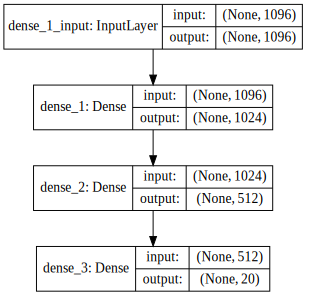

In [25]:
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

### Train the model

In [26]:
import time

In [27]:
start_time = time.time()

history = model.fit(train_data,
                    train_labels, 
                    validation_split=0.1,
                    epochs=10)

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

Train on 1562 samples, validate on 174 samples
Epoch 1/10
1562/1562 [==============================] - 1s 367us/step - loss: 1.3846 - accuracy: 0.7599 - val_loss: 0.1207 - val_accuracy: 0.9943
Epoch 2/10
1562/1562 [==============================] - 0s 233us/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy: 0.9943
Epoch 3/10
1562/1562 [==============================] - 0s 219us/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9943
Epoch 4/10
1562/1562 [==============================] - 0s 207us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9943
Epoch 5/10
1562/1562 [==============================] - 0s 215us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9943
Epoch 6/10
1562/1562 [==============================] - 0s 217us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9943
Epoch 7/10
1562/1562 [==============================] - 0s 219us/step - loss:

### Plot loss and accuracy

In [28]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

In [29]:
import matplotlib.pyplot as plt

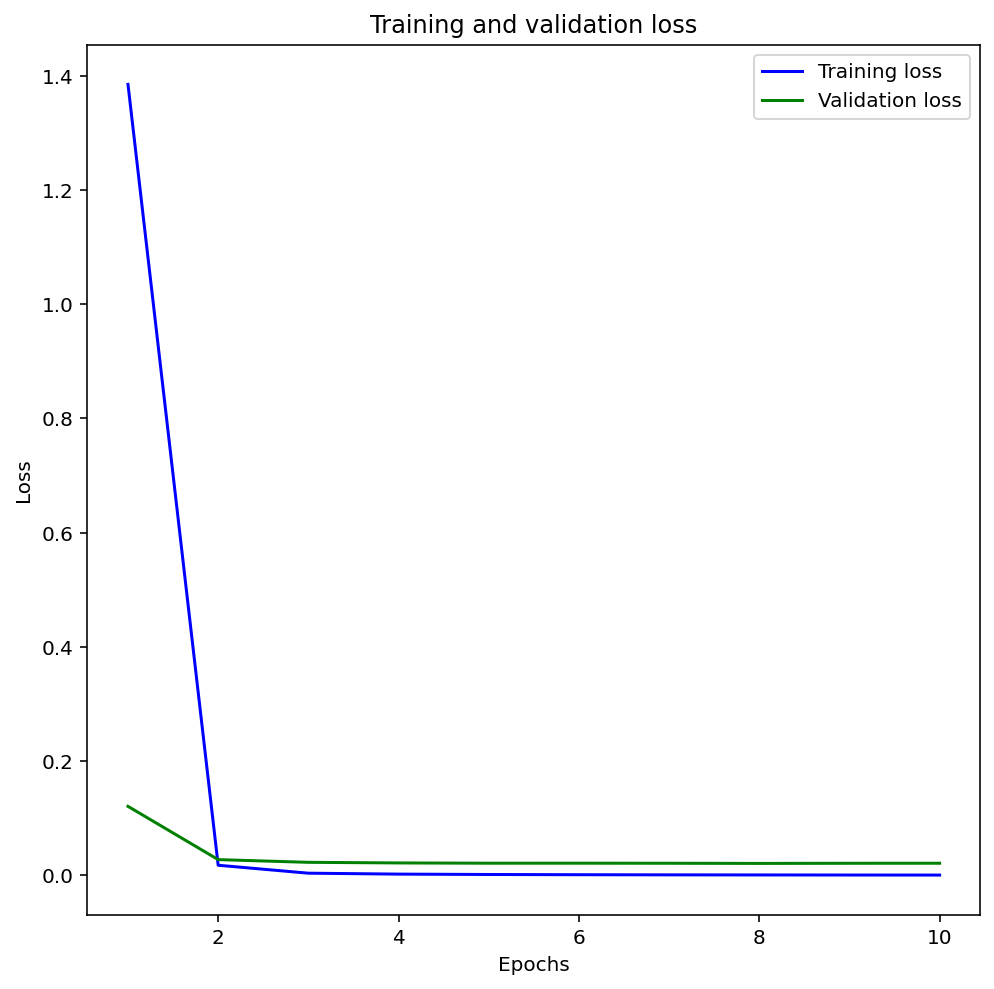

In [30]:
plt.figure(figsize=(8,8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

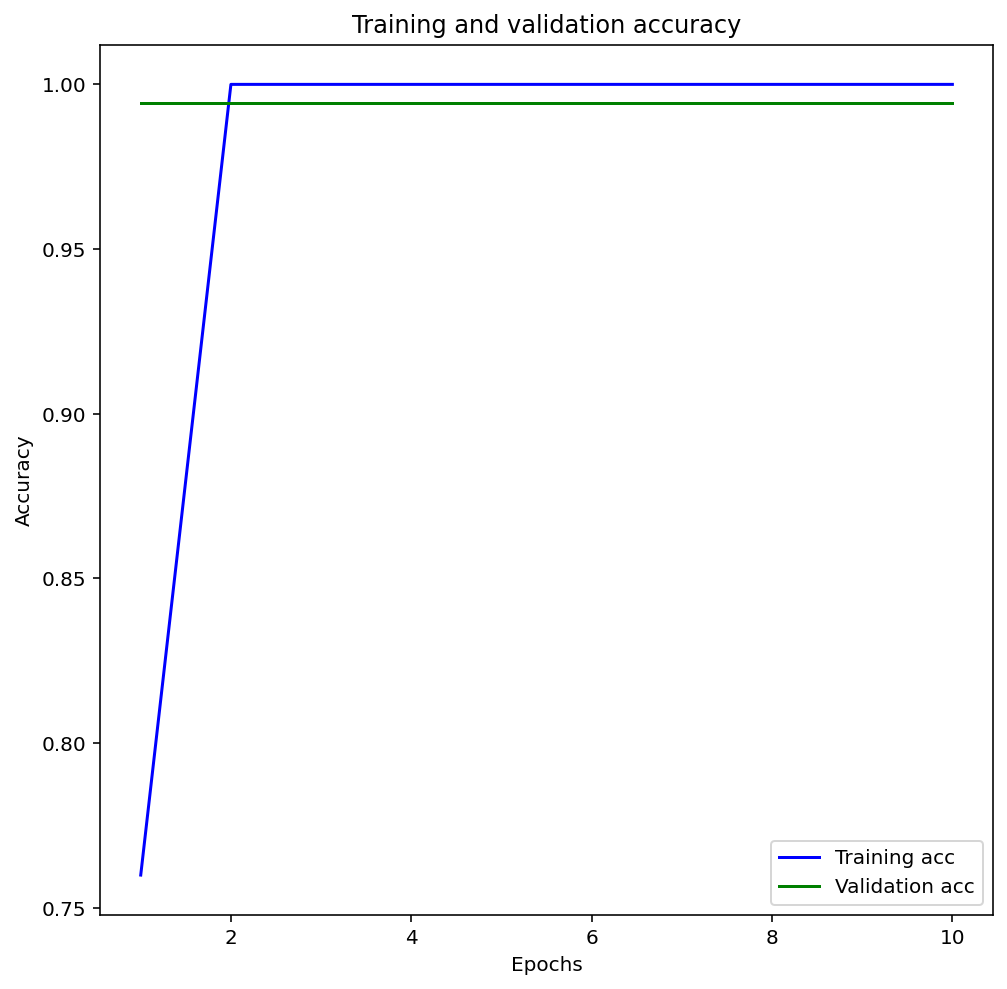

In [31]:
plt.figure(figsize=(8,8))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

## Evaluate the model

### Compute f-score on the test set

In [32]:
test_corpus = [' '.join(corpus.get_tokens(doc_id)) for doc_id in test_doc_ids]
test_data = vectorizer.transform(test_corpus)

In [33]:
test_pred = model.predict(test_data)
# round to nearest integer
test_pred = np.rint(test_pred)

In [34]:
test_pred[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [35]:
from sklearn.metrics import classification_report

In [36]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        35
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00        33
           9       1.00      1.00      1.00         8
          10       1.00      0.97      0.98        29
          11       1.00      0.98      0.99        41
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        25
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00         9
          17       1.00    

/home/nvidia/anaconda3/envs/testenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save model to a file

In [37]:
nn_filename = 'alaska_nn_tfidf_model.h5'
nn_filepath = os.path.join(root_dir, models_dir, nn_filename)

In [38]:
model.save(nn_filepath)

---

## Save `vectorizer` to a file

In [39]:
import dill

In [40]:
vectorizer_filename = f'alaska_tfidf_vectorizer.pkl'
vectorizer_filepath = os.path.join(root_dir, models_dir, vectorizer_filename)

In [41]:
with open(vectorizer_filepath, 'wb') as out:
    dill.dump(vectorizer, out)

---